In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import json
import shutil
import cv2
import tensorflow
import tensorflow.keras as keras

from PIL import Image
from glob import glob
from tensorflow.keras import applications
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image

In [2]:
BASE_PATH = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/'

In [3]:
dirnames = sorted([dirname for dirname in os.listdir(BASE_PATH)])
records = [(os.path.join(BASE_PATH, dirname, filename), dirname) for dirname in dirnames for filename in os.listdir(os.path.join(BASE_PATH, dirname)) if filename.endswith('.png')]

df = pd.DataFrame(records, columns=['image', 'category'])
df.head()

,image,category
0,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
1,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
2,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
3,/kaggle/input/cell-images-for-detecting-malari...,Parasitized
4,/kaggle/input/cell-images-for-detecting-malari...,Parasitized


In [4]:
# Now check class balance
df.category.value_counts()

Uninfected     13779
Parasitized    13779
Name: category, dtype: int64

In [5]:
os.mkdir('train/')
os.mkdir('valid/')

In [8]:
dirpaths = os.listdir(BASE_PATH)
for dirpath in dirpaths:
    category = dirpath.split('/')[-1]
    category_train = glob(os.path.join(BASE_PATH, category, '*.png'))
    shuf = np.random.permutation(category_train)
    
    print(category, len(category_train))
    os.mkdir('train/' + category)
    for i in range(len(category_train)): shutil.copy2(shuf[i], '/kaggle/working/train/' + category + '/')

Parasitized 13779
Uninfected 13779


In [9]:
!ls train/Parasitized/ | wc -l

13779


In [10]:
!ls train/Uninfected/ | wc -l

13779


In [11]:
# Lets create validation data from train data
for dirpath in dirpaths:
    category = dirpath.split('/')[-1]
    category_valid = glob(os.path.join('/kaggle/working/train', category, '*.png'))
    shuf = np.random.permutation(category_valid)
    
    print(category, len(category_valid))
    os.mkdir('valid/' + category)
    for i in range(int(len(category_valid) / 4)): shutil.move(shuf[i], '/kaggle/working/valid/' + category + '/')

Parasitized 13779
Uninfected 13779


In [12]:
!ls valid/Parasitized/ | wc -l

3444


In [13]:
!ls valid/Uninfected/ | wc -l

3444


In [14]:
def display_images(path, color_channel=3, width=100, height=100, number_images=5):
    image_names = os.listdir(path)
    random.shuffle(image_names)
    image_array = np.empty((number_images, width, height, color_channel))
    
    plt.clf()
    fig, axs = plt.subplots(1, number_images, figsize=(25, number_images))
    
    for i, ax, record in zip(range(number_images), axs, image_names[:number_images]):
        img = cv2.imread(os.path.join(path, record))
        img = cv2.resize(img, (width, height))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_array[i] = img
        
        ax.set_title(path.split('/')[-1])
        ax.imshow(img)

    plt.show()

<Figure size 432x288 with 0 Axes>

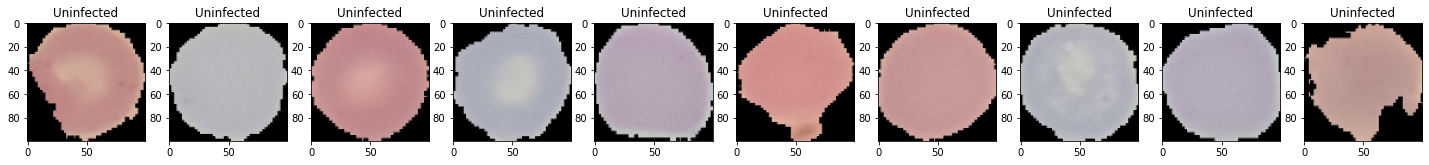

<Figure size 432x288 with 0 Axes>

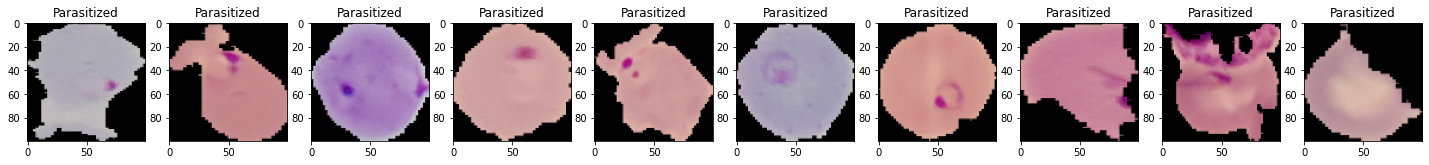

In [15]:
# Let see few images from each category

for dirpath in os.listdir('/kaggle/working/train/'):
    display_images(path='/kaggle/working/train/' + dirpath, number_images=10)

<Figure size 432x288 with 0 Axes>

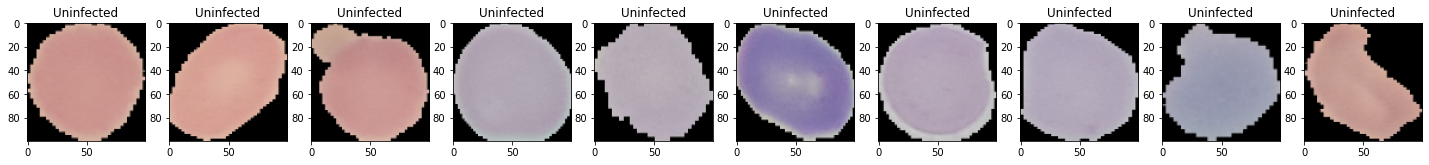

<Figure size 432x288 with 0 Axes>

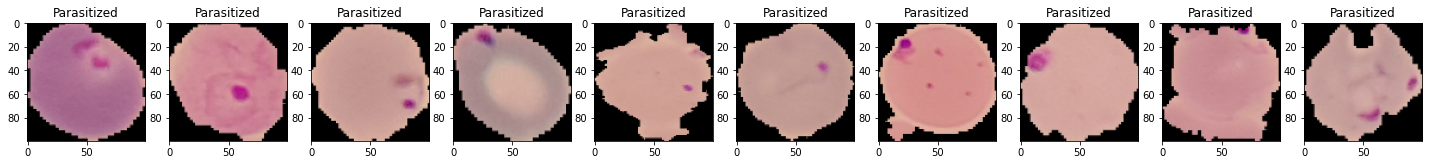

In [16]:
# Let see few images from each category

for dirpath in os.listdir('/kaggle/working/valid/'):
    display_images(path='/kaggle/working/valid/' + dirpath, number_images=10)

In [17]:
batch_size = 150
datagen = image.ImageDataGenerator()
train_datagen = datagen.flow_from_directory('train/', target_size=(110, 110), class_mode='categorical', shuffle=True, batch_size=batch_size)
valid_datagen = datagen.flow_from_directory('valid/', target_size=(110, 110), class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 20670 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.


In [18]:
X_input = Input((110, 110, 3))

# Zero-Padding: pads the border of X_input with zeroes
X = layers.ZeroPadding2D((3, 3))(X_input)

# CONV -> BN -> RELU Block applied to X
X = layers.Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
X = layers.BatchNormalization(axis = 3, name = 'bn0')(X)
X = layers.Activation('relu')(X)

# MORE CONVS
X = layers.MaxPooling2D((2, 2))(X)
#shortcut = X
X = layers.Conv2D(32, (3, 3), strides = (1, 1), padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Conv2D(32, (3, 3), strides = (1, 1), padding="same")(X)
X = layers.BatchNormalization()(X)
#X = layers.add([X, shortcut])
X = layers.Activation('relu')(X)

# MAXPOOL
X = layers.MaxPooling2D((2, 2), name='max_pool')(X)

# FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = layers.Flatten()(X)

# MORE DENSE
X = layers.Dense(128)(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dropout(0.5)(X)

X_output = layers.Dense(2, activation='softmax', name='fc')(X)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = Model(inputs = X_input, outputs = X_output, name='HappyModel')
model.compile(optimizers.Adam(lr=0.0001), 'categorical_crossentropy', ['accuracy'])

In [19]:
callback = keras.callbacks.ModelCheckpoint('best_malaria.h5', monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')

In [20]:
history = model.fit_generator(train_datagen, epochs=10, validation_data=valid_datagen, callbacks=[callback])

Epoch 1/10
138/138 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7134
Epoch 00001: val_accuracy improved from -inf to 0.53136, saving model to best_malaria.h5
138/138 [==============================] - 32s 235ms/step - loss: 0.6223 - accuracy: 0.7134 - val_loss: 1.7336 - val_accuracy: 0.5314
Epoch 2/10
138/138 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8642
Epoch 00002: val_accuracy improved from 0.53136 to 0.59321, saving model to best_malaria.h5
138/138 [==============================] - 31s 226ms/step - loss: 0.3201 - accuracy: 0.8642 - val_loss: 1.2606 - val_accuracy: 0.5932
Epoch 3/10
138/138 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9152
Epoch 00003: val_accuracy did not improve from 0.59321
138/138 [==============================] - 31s 225ms/step - loss: 0.2145 - accuracy: 0.9152 - val_loss: 1.3364 - val_accuracy: 0.5231
Epoch 4/10
138/138 [==============================] - ETA: 0s - loss: 0.16

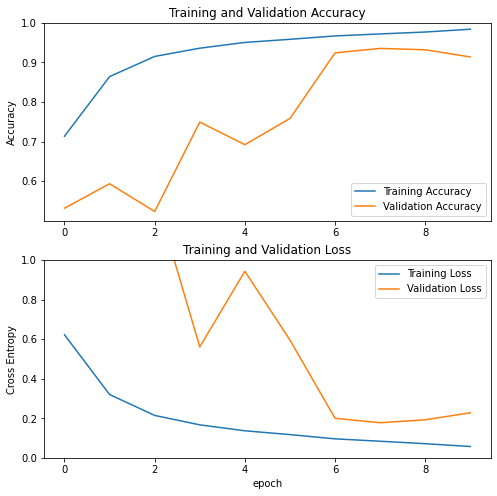

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_weights('/kaggle/input/tbmalaria/best_malaria.h5')
Y_pred = model.predict_generator(valid_datagen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_datagen.classes, y_pred))